# Computational Ghost Imaging

In this notebook we will explore Computational Ghost Imaging with a simple code prototype. 

The idea is to follow a traditional computational ghost imaging technique and understand how it works.

Computational Ghost imaging is much like classical ghost imaging, but instead of generating random illumination patterns in an uncontrollable way(e.g. illuminating a rotating diffuser), the patterns are generated in a computer and feed an intensity or phase modulator (e.g. digital micromirror device or a spatial light modulator). Ths way we can bypass the need to acquire data from the CCD, which may make the system faster.

<p align="center">

  <img src="GI.png" >
  <p style="text-align: center;">
  a.Traditional (two-detector) ghost imaging. b.Computational Ghost Imaging.
  </p>
  

</p>

## 1. Model and algorithm

For the sake of simplicity we will consider:

1. Amplitude modulation for the patterns and the beam reaches the plane of the target as collimated beam (e.g. positioned in the far field)

2. The targets are of transmission type;

Yet note that in reflection it would be more or less the same, and that you can also add some diffraction and the methodology remains valid.


Ghost imaging is an interesting imaging technique that utilizes the correlation of light patterns to construct an image of an object, often without direct line-of-sight between the object and the detector. By correlating the intensities recorded by the bucket detector and the reference patterns, an image of the object is reconstructed. Taking $I_{m}^{i}$ as the intensity measured for each pattern $P_i$ and collected at a bucket detector, which we will say to be equal to $$I_{m}^{i} = \sum Object \cdot P_i$$(as we are considering transmission). The image is then reconstructed (in reference https://www.nature.com/articles/s41598-020-71642-2) in a second-order correlation algorithm as $$I_{rec} = \sum (I_{m}^{i} - mean(I_{m}) ) \cdot P_i$$ or in a logarithimic algorithm to improve contrast as $$I_{rec}=\sum (log_{A}(I_{m}^{i}/mean(I_{m})) \cdot P_i$$ 


 The key principle of ghost imaging is that the image quality depends on the strength of the correlation between the modulated reference beam and the signals captured by the bucket detector. This correlation allows the extraction of spatial information from seemingly random intensity fluctuations, effectively turning pattern correlation into a powerful tool for imaging.

### 1.1. Load sample dataset

We will use the traditional MNIST dataset, with 24x24 images as targets. 

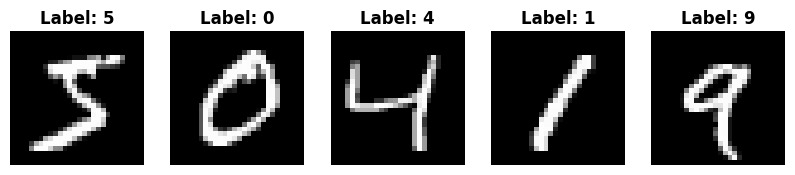

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from PIL import Image

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Check the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

## 1.2. Implementation of the two reconstruction algorithms

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def reconstruction_second_order(measurements,patterns):
    reconstructed_image = np.zeros(patterns[0].shape)
    num_patterns = len(measurements)
    for i in range(num_patterns):
        reconstructed_image += (measurements[i] - np.mean(measurements)) * (patterns[i])

    # Normalize the reconstructed image
    reconstructed_image -= np.min(reconstructed_image)
    reconstructed_image /= np.max(reconstructed_image)

    return reconstructed_image

def reconstruction_log(measurements,patterns):
    
    reconstructed_image = np.zeros(patterns[0].shape)
    num_patterns = len(measurements)
    for i in range(num_patterns):
        reconstructed_image += np.log10(measurements[i]/np.mean(measurements)) * (patterns[i])# - np.mean(patterns[i]))

    # Normalize the reconstructed image
    reconstructed_image -= np.min(reconstructed_image)
    reconstructed_image /= np.max(reconstructed_image)

    return reconstructed_image



## 1.3. Tests with random patterns

Target 0 of 3
Target 1 of 3
Target 2 of 3


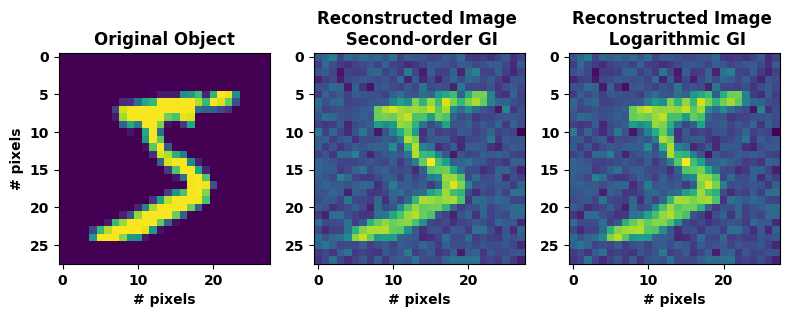

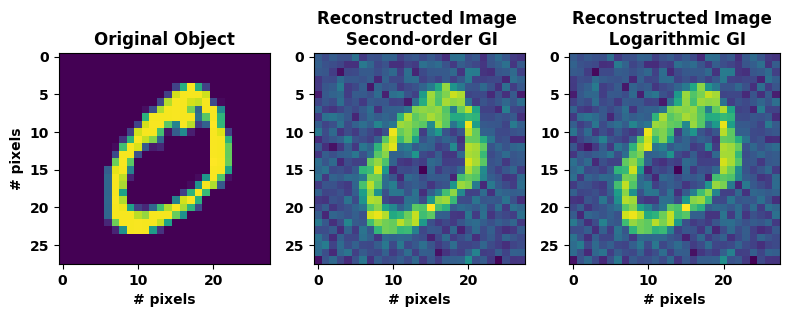

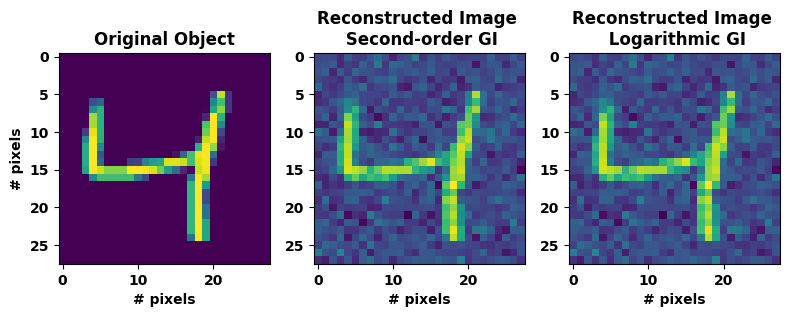

In [8]:
############################
############################
###Set the number of targets, i.e. images to compute below and plot
ntargets = 3
targets = [train_images[i] for i in range(0,ntargets)]#np.random.randint(0, 2, image_size)
image_size = targets[0].shape

############################
############################
###Generate Patterns
# Number of patterns
num_patterns = 5000

# Generate random binary patterns
np.random.seed(0)
patterns = np.random.randint(0, 2, (num_patterns, image_size[0], image_size[1]))

for i,target in enumerate(targets):
    print('Target ' + str(i) + ' of ' +str(len(targets)))

    # Simulate measurements (inner product of each pattern with the object)
    measurements = np.array([np.sum(pattern * target) for pattern in patterns])

    reconstructed_image1 = reconstruction_second_order(measurements=measurements,patterns=patterns)
    reconstructed_image2 = reconstruction_log(measurements=measurements,patterns=patterns)
    # Plot the original and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(target, cmap='viridis')
    ax[0].set_title('Original Object')
    ax[0].set_xlabel("# pixels")
    ax[0].set_ylabel("# pixels")
    ax[1].imshow(reconstructed_image1, cmap='viridis')
    ax[1].set_title('Reconstructed Image \n Second-order GI')
    ax[1].set_xlabel("# pixels")

    ax[2].imshow(reconstructed_image2, cmap='viridis')
    ax[2].set_title('Reconstructed Image \n Logarithmic GI')
    ax[2].set_xlabel("# pixels")

    fig.tight_layout()

## 1.4. Test With Hadamard basis instead of Random
Although the random basis seems sufficient, it may be innefective. In this scenario we can exploit other alternatives, such as the Hadamard basis.
As the Hadamard basis can only be constructed in $2^n\times 2^n$ dimensions, we will first rescale the dataset to 32 pixels per dimension.

In [9]:
def resize_images(images, new_size=(2**5, 2**5)):
    resized_images = np.empty((images.shape[0], new_size[0], new_size[1]), dtype=np.uint8)
    for i, img in enumerate(images):
        pil_img = Image.fromarray(img)
        pil_img = pil_img.resize(new_size, Image.ANTIALIAS)
        resized_images[i] = np.array(pil_img)
    return resized_images

# Resize train and test images to 24x24
train_images_resized = resize_images(train_images)

c:\Users\nunoa\Anaconda2\envs\arduino\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  """


Generated 32x32 Hadamard matrix (basis):
[[ 1  1  1 ...  1  1  1]
 [ 1 -1  1 ... -1  1 -1]
 [ 1  1 -1 ...  1 -1 -1]
 ...
 [ 1 -1  1 ... -1  1 -1]
 [ 1  1 -1 ...  1 -1 -1]
 [ 1 -1 -1 ... -1 -1  1]]


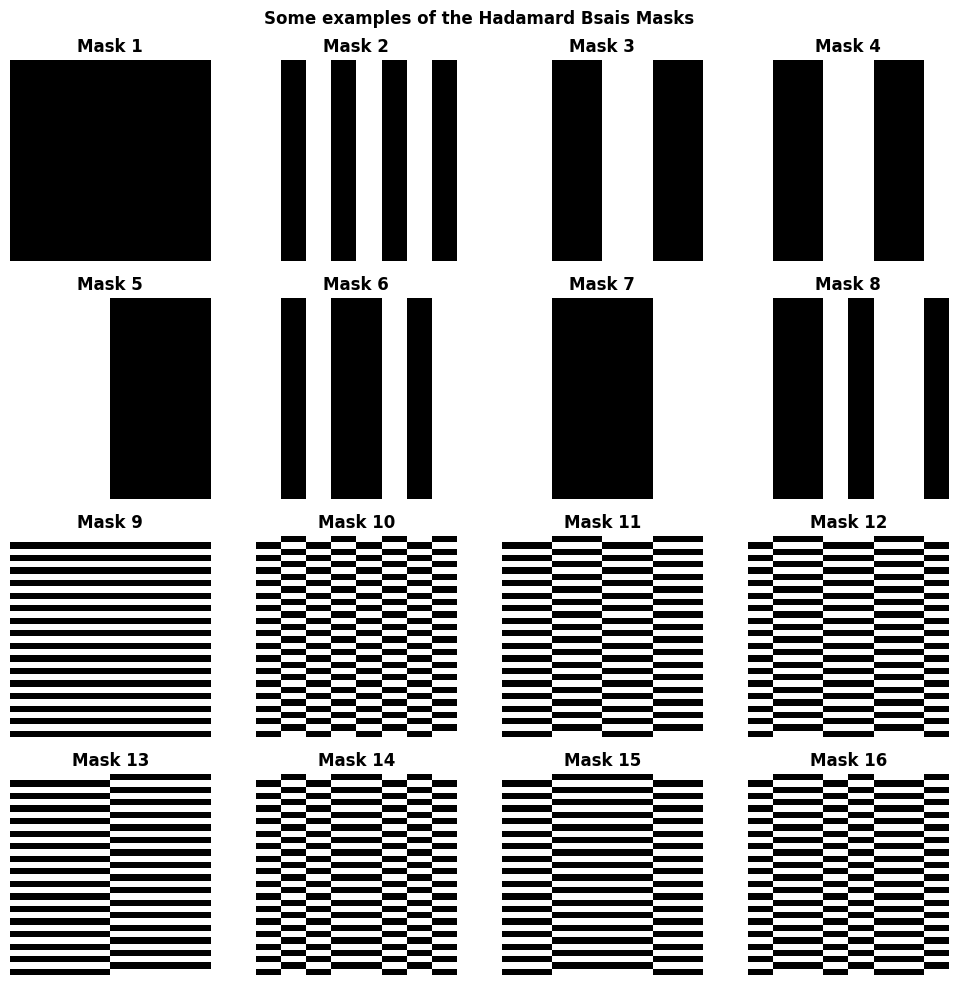

In [10]:
import numpy as np
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

def generate_hadamard_basis(size):
    # Ensure the size is a power of 2
    if not (size & (size - 1) == 0):
        raise ValueError("Size must be a power of 2.")
    
    # Generate the Hadamard matrix of the given size
    H = hadamard(size**2)
    
    
    # Convert from -1/+1 to 0/1
    H_binary = (H + 1) // 2
    
    H_binary = np.array([H_binary[i].reshape(32, 32) for i in range(0,size*size)])
    return H, H_binary

# Desired size
size = 32

# Generate the 32x32 Hadamard matrix
hadamard_matrix, hadamard_matrix_binary = generate_hadamard_basis(size)

print(f"Generated {size}x{size} Hadamard matrix (basis):")
print(hadamard_matrix)


# If you need to visualize individual masks, you can do it like this:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Some examples of the Hadamard Bsais Masks')

for i, ax in enumerate(axes.flatten()):
    ax.imshow(hadamard_matrix_binary[i*4], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Mask {i+1}')

plt.tight_layout()
plt.show()

Target 0 of 3
Target 1 of 3
Target 2 of 3


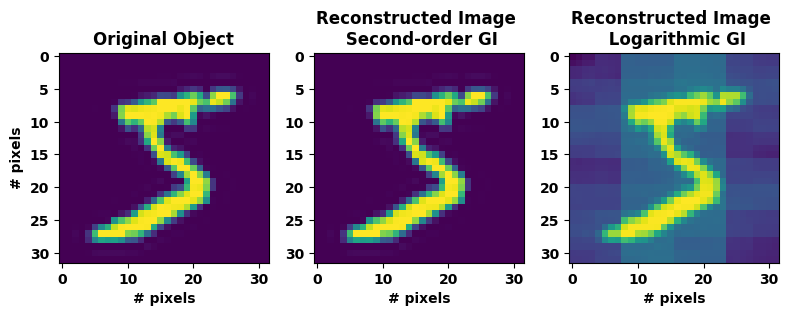

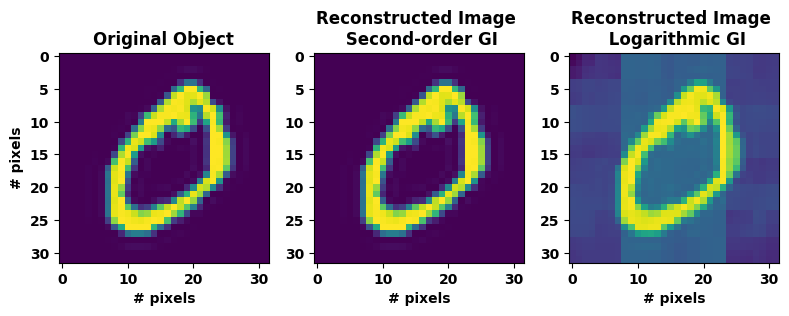

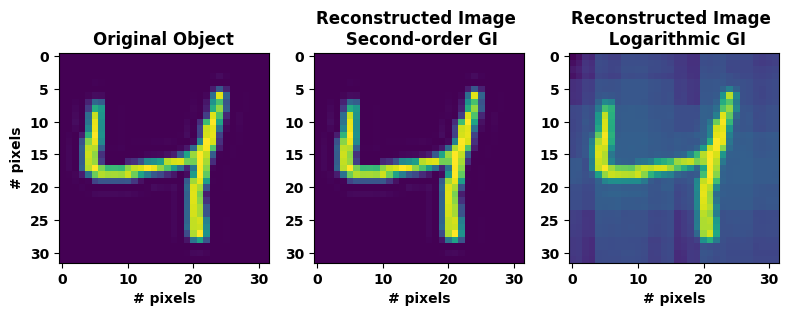

In [11]:
############################
############################
###Set the number of targets, i.e. images to compute below and plot
ntargets = 3
targets = [train_images_resized[i] for i in range(0,ntargets)]#np.random.randint(0, 2, image_size)
image_size = targets[0].shape

############################
############################



for i,target in enumerate(targets):
    print('Target ' + str(i) + ' of ' +str(len(targets)))

    # Simulate measurements (inner product of each pattern with the object)
    measurements = np.array([np.sum(pattern * target) for pattern in hadamard_matrix_binary])

    reconstructed_image1 = reconstruction_second_order(measurements=measurements,patterns=hadamard_matrix_binary)
    reconstructed_image2 = reconstruction_log(measurements=measurements,patterns=hadamard_matrix_binary)
    # Plot the original and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(target, cmap='viridis')
    ax[0].set_title('Original Object')
    ax[0].set_xlabel("# pixels")
    ax[0].set_ylabel("# pixels")
    ax[1].imshow(reconstructed_image1, cmap='viridis')
    ax[1].set_title('Reconstructed Image \n Second-order GI')
    ax[1].set_xlabel("# pixels")

    ax[2].imshow(reconstructed_image2, cmap='viridis')
    ax[2].set_title('Reconstructed Image \n Logarithmic GI')
    ax[2].set_xlabel("# pixels")

    fig.tight_layout()